In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:

# Step 1: Download CIFAR-10 Dataset (without any transformations)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

100%|██████████| 170M/170M [00:04<00:00, 42.4MB/s]


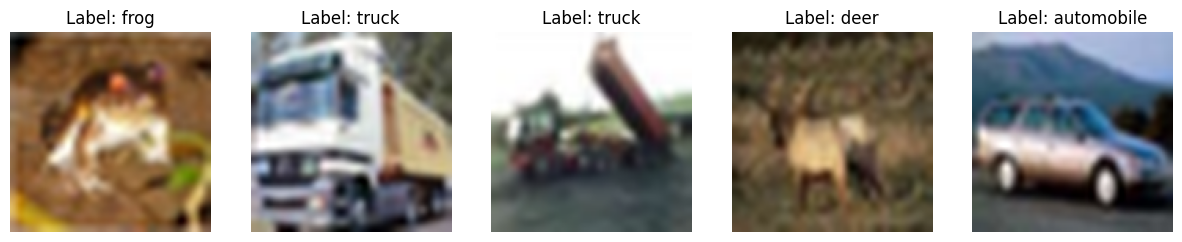

In [8]:
# Function to upscale the image for better visualization
def upscale_image(img, size=(128, 128)):
    return img.resize(size, Image.Resampling.LANCZOS)

# Visualize the first 5 raw images from CIFAR-10, upscaled to 128x128
def visualize_upscaled_images(dataset, num_images=5, size=(128, 128)):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        # dataset[i] now returns a transformed image, so we need to get the original image
        img, label = dataset.data[i], dataset.targets[i]  # Access original data and targets
        img = Image.fromarray(img) # Convert the image back to a PIL Image
        img = upscale_image(img, size=size)  # Upscale the image
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {dataset.classes[label]}")
        axes[i].axis('off')  # Hide axes for better display
    plt.show()

# Visualize the first 5 images, upscaled
visualize_upscaled_images(train_dataset, num_images=5)


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/transforms.py:1657: UserWarning: Scale and ratio should be of kind (min, max)
  warnings.warn("Scale and ratio should be of kind (min, max)")
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Visualizing enhanced augmentations:


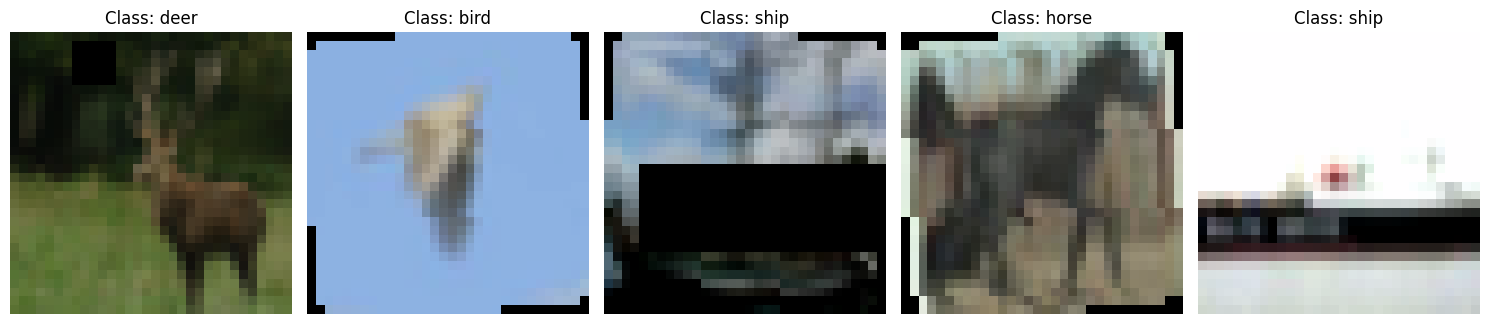


Data loaded with:
- Training samples: 50000
- Test samples: 10000
- Batch size: 256
- Using optimized contrastive augmentations


In [9]:
# Enhanced Augmentation Pipeline for Contrastive Learning
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2),
    #transforms.RandomApply([transforms.GaussianBlur(kernel_size=1)], p=0.2),
    transforms.RandomResizedCrop(32, scale=(0.9, 1.0)),
    transforms.RandomRotation(10),  # Added moderate rotation (±15 degrees)
     transforms.RandomApply([transforms.GaussianBlur(kernel_size=1)], p=0.2),
      transforms.RandomErasing(
        p=0.1,  # Reduced probability
        scale=(0.02, 0.01),  # Smaller area
        ratio=(0.3, 3.3),  # Constrain aspect ratio
        value='random'  # Try random values instead of zero
    ),  # Random erasing for contrastive learning
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                       std=[0.2470, 0.2435, 0.2616])  # CIFAR-10 stats
])

# Test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                       std=[0.2470, 0.2435, 0.2616])
])
# Dataset without augmentations for classifier
classifier_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
    ])

# Enhanced Augmentation Pipeline for Contrastive Learning
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2),
    transforms.RandomResizedCrop(32, scale=(0.9, 1.0)),
    transforms.RandomRotation(10),  # Added moderate rotation (±15 degrees)
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=1)], p=0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3),  # Random erasing must come after ToTensor()
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                       std=[0.2470, 0.2435, 0.2616])  # CIFAR-10 stats
])

# Test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                       std=[0.2470, 0.2435, 0.2616])
])

# Dataset without augmentations for classifier
classifier_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])

# Load datasets
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

# Visualization function
def visualize_augmentations(dataset, n_samples=5):
    plt.figure(figsize=(15, 4))
    for i in range(n_samples):
        img, label = dataset[np.random.randint(len(dataset))]
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2470, 0.2435, 0.2616])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        plt.subplot(1, n_samples, i+1)
        plt.imshow(img)
        plt.title(f"Class: {train_dataset.classes[label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize
print("Visualizing enhanced augmentations:")
visualize_augmentations(train_dataset)

print("\nData loaded with:")
print(f"- Training samples: {len(train_dataset)}")
print(f"- Test samples: {len(test_dataset)}")
print(f"- Batch size: {train_loader.batch_size}")
print(f"- Using optimized contrastive augmentations")


In [10]:
# Custom ContrastiveDataset to generate augmented pairs
class ContrastiveDataset(torch.utils.data.Dataset):  # Changed: Added the custom dataset for contrastive learning
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]
        # Convert the image back to PIL Image before augmentation
        img = transforms.ToPILImage()(img)  # Add this line to fix the error

        # Generate two augmented versions of the same image
        aug1 = self.transform(img)  # First augmentation
        aug2 = self.transform(img)  # Second augmentation

        return aug1, aug2, label


# Creating Contrastive Dataset and DataLoader
contrastive_train_dataset = ContrastiveDataset(train_dataset, train_transform)  # Changed: Using the custom dataset
train_loader = DataLoader(contrastive_train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, output_dim=128):
        super(ProjectionHead, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)


In [11]:

class ContrastiveModel(nn.Module):
    def __init__(self, backbone='resnet50', feat_dim=128):
        super(ContrastiveModel, self).__init__()

        # Choose ResNet backbone
        if backbone == 'resnet18':
            self.backbone = models.resnet18(pretrained=True)
            in_features = 512
        elif backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            in_features = 2048

        # Remove the final classification layer (to use as feature extractor)
        self.backbone.fc = nn.Identity()

        # Projection head to get embeddings
        self.projector = ProjectionHead(input_dim=in_features, output_dim=feat_dim)

    def forward(self, x):
        features = self.backbone(x)
        embeddings = self.projector(features)
        return embeddings

    def compute_similarity(self, x1, x2):
        z1 = self(x1)
        z2 = self(x2)
        return F.cosine_similarity(z1, z2, dim=1)


In [12]:
# Step 2: Create the contrastive dataset using your original CIFAR-10 dataset and transformations
contrastive_train_dataset = ContrastiveDataset(train_dataset, train_transform)

# Step 3: Create a DataLoader for the contrastive dataset
train_loader = DataLoader(contrastive_train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)


In [13]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        # Normalize the embeddings
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)

        # Compute cosine similarity between z1 and z2
        similarity_matrix = torch.matmul(z1, z2.T) / self.temperature

        # Labels are [0, 1, 2, ..., batch_size-1]
        labels = torch.arange(z1.size(0), device=z1.device)

        # Compute the loss using cross entropy (NCE loss)
        loss = F.cross_entropy(similarity_matrix, labels)
        return loss
from torch.optim.lr_scheduler import StepLR



In [14]:
def train_contrastive(model, train_loader, num_epochs=20, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = ContrastiveLoss(temperature=0.1)

    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate scheduler

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        batch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for aug1, aug2, _ in batch_bar:
            aug1, aug2 = aug1.to(device), aug2.to(device)

            z1 = model(aug1)
            z2 = model(aug2)

            loss = criterion(z1, z2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_bar.set_postfix(loss=f"{loss.item():.4f}")

        scheduler.step()  # Update the learning rate
        print(f"Epoch {epoch+1} - Avg Loss: {epoch_loss/len(train_loader):.4f}")

    return model


In [15]:
# Ensure the model is on the correct device (GPU or CPU)
model = ContrastiveModel(backbone='resnet18', feat_dim=128).to(device)

# Print model architecture to verify
print(model)

# Initialize the optimizer and contrastive loss
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = ContrastiveLoss(temperature=0.1)

# Start the training process (for 10 epochs)
trained_model = train_contrastive(model, train_loader, num_epochs=10, lr=1e-3)

# Optionally save the trained model after training
torch.save(trained_model.state_dict(), 'contrastive_model.pth')

print("Model training complete and saved.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


ContrastiveModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

Epoch 1/10: 100%|██████████| 196/196 [02:25<00:00,  1.35it/s, loss=0.3161]


Epoch 1 - Avg Loss: 1.1686


Epoch 2/10: 100%|██████████| 196/196 [02:18<00:00,  1.42it/s, loss=0.0899]


Epoch 2 - Avg Loss: 0.4061


Epoch 3/10: 100%|██████████| 196/196 [02:16<00:00,  1.44it/s, loss=0.1450]


Epoch 3 - Avg Loss: 0.3147


Epoch 4/10: 100%|██████████| 196/196 [02:18<00:00,  1.41it/s, loss=0.0600]


Epoch 4 - Avg Loss: 0.2684


Epoch 5/10: 100%|██████████| 196/196 [02:19<00:00,  1.40it/s, loss=0.0961]


Epoch 5 - Avg Loss: 0.2345


Epoch 6/10: 100%|██████████| 196/196 [02:23<00:00,  1.37it/s, loss=0.1155]


Epoch 6 - Avg Loss: 0.1913


Epoch 7/10: 100%|██████████| 196/196 [02:22<00:00,  1.37it/s, loss=0.0951]


Epoch 7 - Avg Loss: 0.1799


Epoch 8/10: 100%|██████████| 196/196 [02:19<00:00,  1.40it/s, loss=0.0404]


Epoch 8 - Avg Loss: 0.1728


Epoch 9/10: 100%|██████████| 196/196 [02:17<00:00,  1.42it/s, loss=0.0678]


Epoch 9 - Avg Loss: 0.1676


Epoch 10/10: 100%|██████████| 196/196 [02:19<00:00,  1.40it/s, loss=0.0680]

Epoch 10 - Avg Loss: 0.1654
Model training complete and saved.


In [25]:
# Load the saved model
def load_model(model_path, device):
    # Reinitialize the model with the same architecture you used during training
    model = ContrastiveModel(backbone='resnet18', feat_dim=128).to(device)

    # Load the model weights
    model.load_state_dict(torch.load(model_path))

    # Make sure to call eval() for inference
    model.eval()

    return model

# Load the saved model and use it for further tasks
model_path = '/content/contrastive_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = load_model(model_path, device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
def track_similarity(model, val_loader, device):
    """Track similarity between positive and negative pairs"""
    model.eval()  # Set the model to evaluation mode
    pos_sim, neg_sim = [], []

    with torch.no_grad():  # Disable gradient computation for inference
        for (aug1, aug2, _) in val_loader:  # Now unpack 3 values, but ignore the label
            aug1, aug2 = aug1.to(device), aug2.to(device)  # Move data to device (CPU/GPU)

            z1 = model(aug1)  # Get embeddings for first augmentation
            z2 = model(aug2)  # Get embeddings for second augmentation

            # Positive pairs (same image)
            pos_sim.append(F.cosine_similarity(z1, z2))

            # Negative pairs (different images)
            neg_sim.append(F.cosine_similarity(z1, torch.roll(z2, 1, 0)))  # Roll to create negative pair

    # Calculate average cosine similarities for positive and negative pairs
    avg_pos_sim = torch.mean(torch.cat(pos_sim)).item()
    avg_neg_sim = torch.mean(torch.cat(neg_sim)).item()

    return avg_pos_sim, avg_neg_sim



Final Metrics after training:
Positive Pair Similarity: 0.8839
Negative Pair Similarity: 0.0040


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


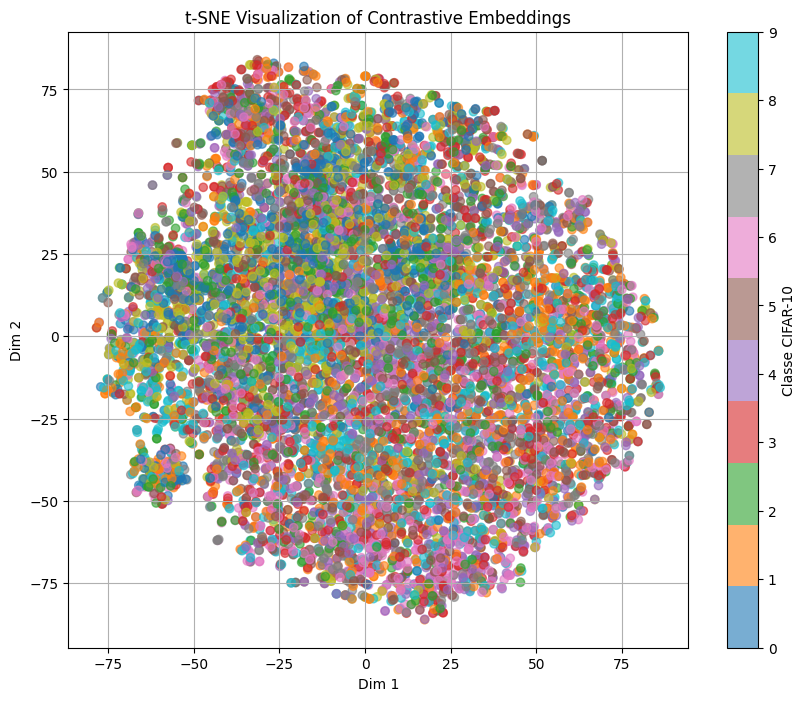

In [18]:
# Step 2: Create the contrastive dataset for validation using CIFAR-10 and transformations
contrastive_val_dataset = ContrastiveDataset(test_dataset, train_transform)  # Same transformation as for training

# Step 3: Create a DataLoader for the contrastive validation dataset
val_loader = DataLoader(contrastive_val_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

# Now you can track similarity after training
model.eval()  # Set model to evaluation mode
pos_sim, neg_sim = track_similarity(model, val_loader, device)

# Print the final similarity metrics
print(f"\nFinal Metrics after training:")
print(f"Positive Pair Similarity: {pos_sim:.4f}")
print(f"Negative Pair Similarity: {neg_sim:.4f}")
def extract_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        # Modified: Now unpack 3 values: aug1, aug2, label
        for aug1, aug2, labels in dataloader:
            # Use aug1 for embedding extraction (you can use aug2 as well)
            images = aug1.to(device)
            features = model.backbone(images)  # ResNet18 output # Changed: Using backbone instead of encoder
            embeddings = model.projector(features)  # projection head output # Changed: Using projector instead of projection_head
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels.cpu())
    all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    return all_embeddings, all_labels
embeddings, labels = extract_embeddings(model, val_loader, device)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, ticks=range(10), label='Classe CIFAR-10')
plt.title("t-SNE Visualization of Contrastive Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()



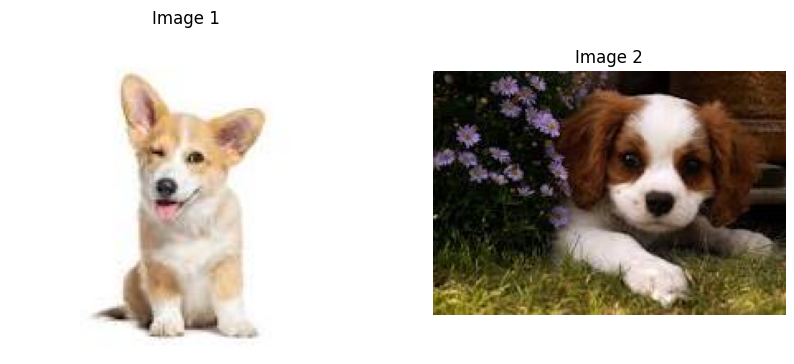

Cosine Similarity between the two images: 0.9594


In [43]:
# Function to preprocess the image
def preprocess_image(image_path, transform, device):
    img = Image.open(image_path).convert('RGB')  # Ensure image is in RGB format
    img = transform(img).unsqueeze(0).to(device)  # Apply transformation and add batch dimension
    return img


# Function to compute cosine similarity between two images
def compute_cosine_similarity(image1_path, image2_path, model, transform, device):
    img1 = preprocess_image(image1_path, transform, device)
    img2 = preprocess_image(image2_path, transform, device)

    with torch.no_grad():
        # Get the embeddings for both images
        emb1 = model(img1)
        emb2 = model(img2)

        # Compute cosine similarity between the embeddings
        cos_sim = F.cosine_similarity(emb1, emb2)

    return cos_sim.item()
# Define transformation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])



image1_path = '/content/dog2.jpeg'
image2_path = '/content/dog1.jpeg'

# Calculate cosine similarity
cosine_similarity = compute_cosine_similarity(image1_path, image2_path, model, test_transform, device)
# Load the images
img1 = Image.open(image1_path)
img2 = Image.open(image2_path)

# Plot the images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display image 1
ax[0].imshow(img1)
ax[0].axis('off')
ax[0].set_title("Image 1")

# Display image 2
ax[1].imshow(img2)
ax[1].axis('off')
ax[1].set_title("Image 2")

# Show the plot
plt.show()
print(f"Cosine Similarity between the two images: {cosine_similarity:.4f}")

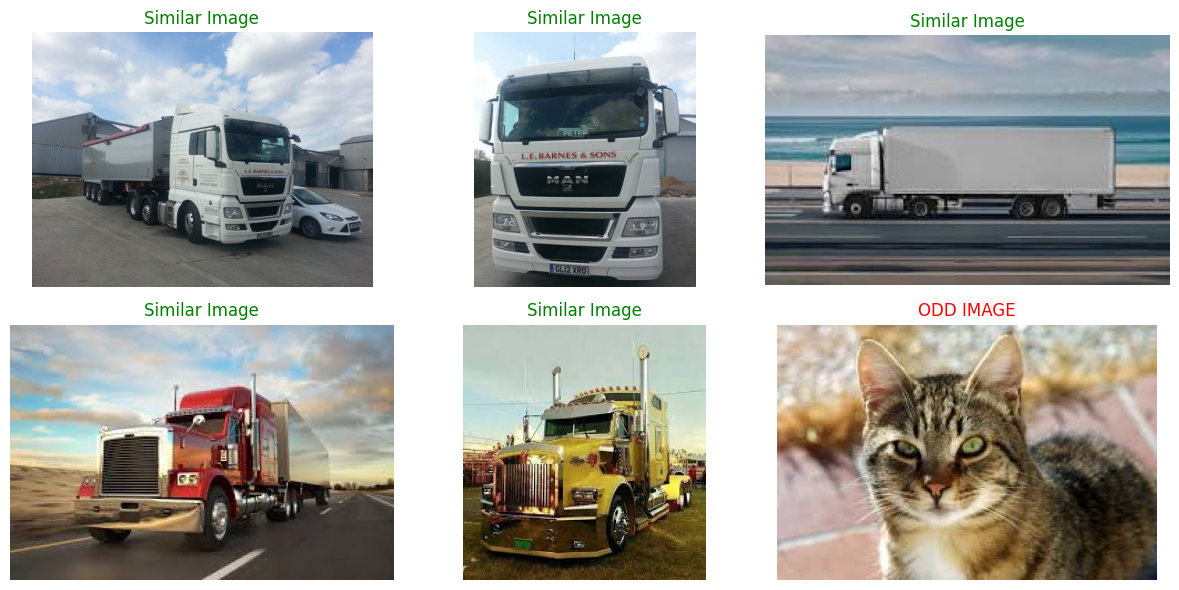

In [20]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import torchvision.transforms as transforms

def load_model(model_path, device):
    model = ContrastiveModel(backbone='resnet18', feat_dim=128).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def preprocess_image(image_path, transform, device):
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)
    return img

def extract_embeddings(image_paths, model, transform, device):
    embeddings = []
    for img_path in image_paths:
        img = preprocess_image(img_path, transform, device)
        with torch.no_grad():
            embedding = model(img)
        embeddings.append(embedding.cpu().numpy().flatten())
    return np.array(embeddings)

def find_odd_one_out(image_paths, model, transform, device):
    embeddings = extract_embeddings(image_paths, model, transform, device)
    cos_sim_matrix = cosine_similarity(embeddings)
    avg_similarities = cos_sim_matrix.mean(axis=1)
    odd_idx = np.argmin(avg_similarities)
    return odd_idx

# Example usage
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_model('/content/contrastive_model.pth', device)

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image_paths = [
        '/content/truck1.jpeg',
        '/content/truck2.jpeg',
        '/content/truck3.jpeg',
        '/content/truck4.jpeg',
        '/content/truck5.jpeg',
        '/content/cat1.jpeg'
    ]

    odd_idx = find_odd_one_out(image_paths, model, test_transform, device)

    # Display all images with the odd one highlighted
    plt.figure(figsize=(12, 6))
    for i, img_path in enumerate(image_paths):
        plt.subplot(2, 3, i+1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')

        # Highlight the odd image with a red border
        if i == odd_idx:
            plt.title("ODD IMAGE", color='red')
            plt.gca().patch.set_edgecolor('red')
            plt.gca().patch.set_linewidth(5)
        else:
            plt.title("Similar Image", color='green')

    plt.tight_layout()
    plt.show()